Analyzing discord messages is fun.

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

### Data preparation
Load data and do some data preparation.chat.

In [65]:
df = pd.read_csv('chat.csv')
df.drop(columns=['AuthorID', 'Reactions'], inplace=True)
df['Author'] = df['Author'].str.replace(r"#[0-9]+", "")  # leave only usernames

df['Content'] = df['Content'].fillna("")
df.insert(2, 'Time', pd.to_datetime(df['Date']).dt.time)
df['Date'] = pd.to_datetime(df['Date']).dt.date

df.columns

Index(['Author', 'Date', 'Time', 'Content', 'Attachments'], dtype='object')

### Basic information about messages in the dataset

In [66]:
def get_the_highest_streak(msgs_per_day: pd.Series) -> tuple:
    """
    Finds and returns the highest messaging streak found in the dataset.
    Think of it as snapchat fires. But on discord.

    :param msgs_per_day: series where index represents every day when message has been sent
    :return: start of the streak, end of the streak, duration of the streak
    """
    days = msgs_per_day.sort_index().index

    start, end, prev, streak = 0, 0, 0, 0
    max_start, max_end, max_streak = 0, 0, 0
    one_day = pd.DateOffset()

    for day in days:
        if start == 0:
            start, prev = day, day
        elif prev + one_day == day:
            prev = day
            streak += 1
        else:
            streak = streak + 1 if streak != 0 else 0
            end = prev if streak != 0 else 0
            if streak > max_streak:
                max_start, max_end, max_streak = start, end, streak
            start, prev, end, streak = 0, 0, 0, 0

    if streak > max_streak:
        return start, 0, streak

    return max_start, max_end, max_streak

In [67]:
total_msgs = len(df)

messages = df['Author'].value_counts()
author_1, author_2 = messages.index.to_numpy()
msgs_per_author = messages.values

date_val_cnts = df['Date'].value_counts()
max_msg_day, max_msg_cnt = date_val_cnts.index[0], date_val_cnts[0]
msgs_info = date_val_cnts.describe()

start, end, streak = get_the_highest_streak(date_val_cnts)

index = ['Total message count', f"{author_1}'s total message count", f"{author_2}'s total message count",
         'Number of days in dataset',
         'Most messages per day date', 'Most messages per day count',
         'Messages per day mean', 'Messages per day median', 'Messages per day std',
         'Highest message streak (days)', 'Begin of the highest streak', 'End of the highest streak']
data = [total_msgs, msgs_per_author[0], msgs_per_author[1], int(msgs_info[0]),
        max_msg_day, max_msg_cnt,
        msgs_info[1], msgs_info[5], msgs_info[2],
        streak, start, "ongoing" if end == 0 and streak != 0 else end]

basic_info_df = pd.DataFrame(index=index, data=data, columns=['Data'])
print(basic_info_df)

                                     Data
Total message count                230223
phoda's total message count        146760
Korina's total message count        83463
Number of days in dataset             518
Most messages per day date     2022-05-14
Most messages per day count          1577
Messages per day mean          444.445946
Messages per day median             409.5
Messages per day std           297.597277
Highest message streak (days)         178
Begin of the highest streak    2022-01-05
End of the highest streak      2022-07-01


### Message count analysis
Analysing the number of messages sent per day.
Since the dataset is quite big, I'll also plot the regression line to get the better idea of the data.

In [68]:
def get_messages_per_day(_df: pd.DataFrame, missing_days = True) -> pd.DataFrame:
    """
    Creates and returns a new dataframe with information how many messages were sent every day since beginning of messages in original dataframe until the last day in the dataset. It includes the days when no conversation took place.
    :param missing_days: boolean representing if missing days should be included in the dataset
    :param _df: "raw" dataframe containing all messages
    :return: dataframe consisting of two columns: Day and Message count for that day
    """
    val_cnts = _df['Date'].value_counts()
    ret = pd.DataFrame(val_cnts).reset_index()
    ret.rename(columns={'index': 'Day', 'Date': 'Message count'}, inplace=True)
    if missing_days:
        missing_days = pd.date_range(start=ret['Day'].min(), end=ret['Day'].max())\
            .difference(ret['Day']).values
        ret = pd.concat(
            [ret,
             pd.DataFrame(data=[[pd.to_datetime(day).date(), 0] for day in missing_days], columns=['Day', 'Message count'])],
            ignore_index=True)
    ret.sort_values(by='Day', inplace=True)
    return ret

<AxesSubplot:title={'center':'Message count per day'}, xlabel='Day', ylabel='Message count'>

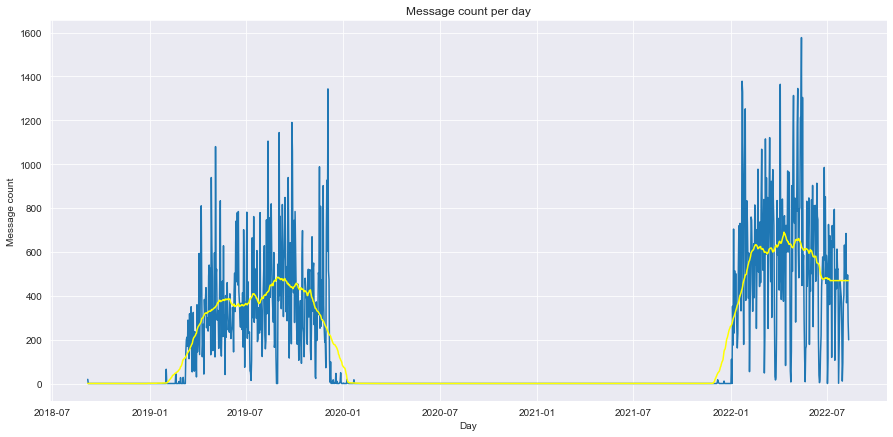

In [69]:
msgs_per_day = get_messages_per_day(df)

plt.figure(figsize=(15, 7))
sns.lineplot('Day', 'Message count', data=msgs_per_day).set_title('Message count per day')

# Plot the regression line
from sklearn.neighbors import KNeighborsRegressor

days = np.array([i for i in range(0, len(msgs_per_day))])

knr = KNeighborsRegressor(n_neighbors=int(0.05 * len(msgs_per_day)), n_jobs=-1, weights='uniform')
knr.fit(X=days.reshape(-1, 1), y=msgs_per_day['Message count'])

predited = knr.predict(days.reshape(-1, 1))
sns.lineplot(msgs_per_day['Day'], predited, color='yellow')


## Overall distribution of messages per day

If we treat messages per day as a random variable, what kind of distribution would it have?

Text(0.5, 1.0, 'Distribution of messages per day')

<Figure size 1080x504 with 0 Axes>

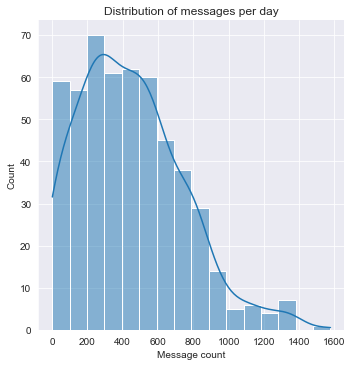

In [70]:
plt.figure(figsize=(15, 7))
sns.displot(data=get_messages_per_day(df, missing_days=False), x='Message count', kde=True)
plt.title("Distribution of messages per day")

## Overal distribution of messages per day for individual author

After we took a look at the overall distribution, now we'll take a look at the distributions for every author.
The question is: are those two distributions the same?

Text(0.5, 1.0, 'Distribution of messages per day for Korina')

<Figure size 1080x504 with 0 Axes>

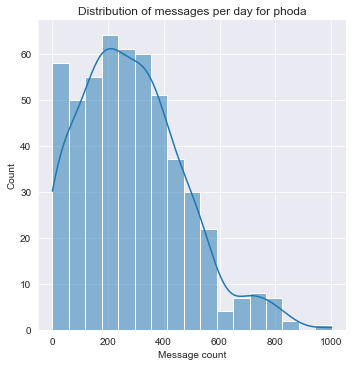

<Figure size 1080x504 with 0 Axes>

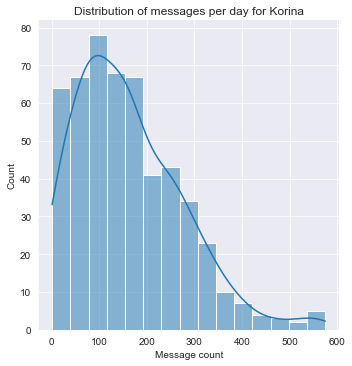

In [71]:
msgs_per_day_a1 = get_messages_per_day(df[df['Author'] == author_1], missing_days=False)
msgs_per_day_a2 = get_messages_per_day(df[df['Author'] == author_2], missing_days=False)

plt.figure(figsize=(15,7))
sns.displot(data=msgs_per_day_a1, x='Message count', kde=True)
plt.title(f"Distribution of messages per day for {author_1}")

plt.figure(figsize=(15,7))
sns.displot(data=msgs_per_day_a2, x='Message count', kde=True)
plt.title(f"Distribution of messages per day for {author_2}")


In [72]:
# create a combined dataset 
msgs_per_day_a1['Author'] = author_1
msgs_per_day_a2['Author'] = author_2

combined_author_msgs = pd.concat([msgs_per_day_a1, msgs_per_day_a2], ignore_index=True)

## Kernel density visualization of the distributions

Text(0.5, 1.0, 'Distribution of the messages per author')

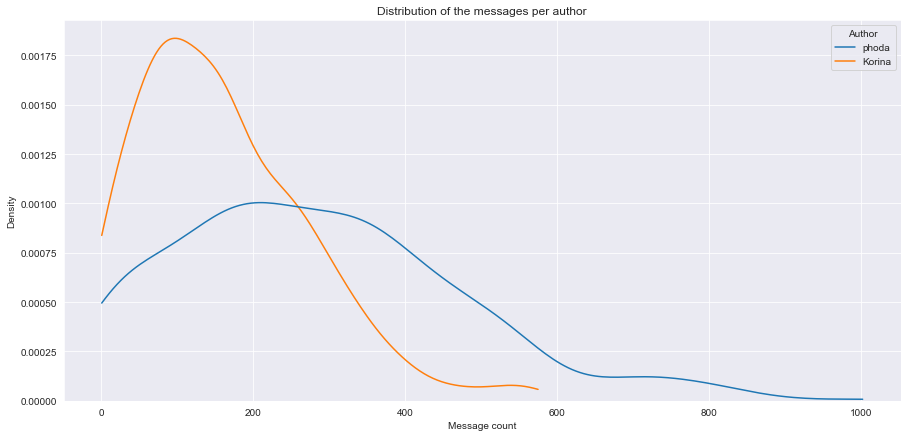

In [73]:
plt.figure(figsize=(15,7))
sns.kdeplot(data=combined_author_msgs, x='Message count', hue='Author', cut=0)
plt.title("Distribution of the messages per author")

So far, we can conclude that distributions deviate significantly from normal distribution and it's negatively skewed.

## Boxplot visualization of the distributions

Text(0.5, 1.0, 'Distribution of messages per author')

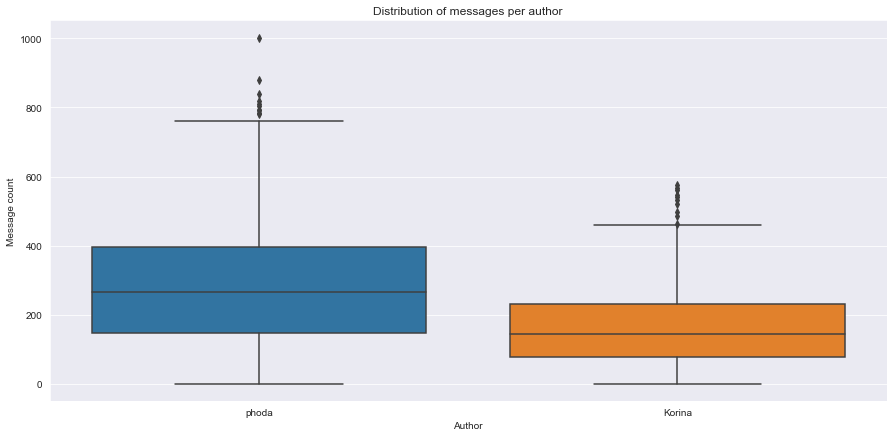

In [74]:
plt.figure(figsize=(15,7))
sns.boxplot(data=combined_author_msgs, x='Author', y='Message count')
plt.title("Distribution of messages per author")

## Cumulative distribution for each author

Text(0.5, 1.0, 'Cumulative distribution')

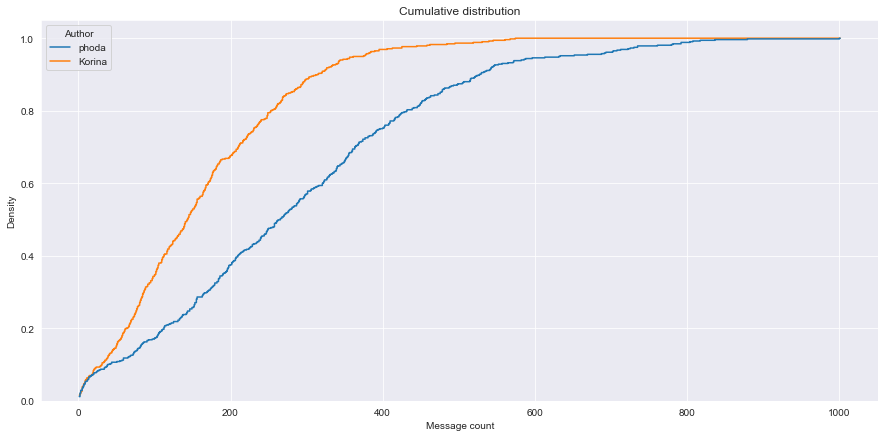

In [75]:
plt.figure(figsize=(15,7))
sns.histplot(data=combined_author_msgs, x='Message count', hue='Author', stat='density', bins=len(combined_author_msgs), element='step', fill=False, cumulative=True, common_norm=False)
plt.title("Cumulative distribution")

## Statistical tests to determine whether the distributions are equal

## Mann-Whitney U Test
Null hypothesis: the two groups have the same distribution
Alternative hypothesis: one group has larger (or smaller) values than the other
Assumption: variances of two groups are equal

### Test to determine if variances are equal
In order to properly use the Mann-Whitney U Test, we need to determine whether variances differ significantly. The most common test used for that is F-test, however F-test is very sensitive to normality of the data (which here most often won't be the case, instead it's usually a positively skewed distribution). Instead, I'll use more robust variants of the test. There are two options: Bartlett's and Levene's test. Levene's test is an alternative to Bartlett's when there are significant deviations from normality. I'll perform both tests and compare the results.

Null hypothesis: all input samples are from populations with equal variances

In [76]:
alpha = 0.05 # significance level

In [77]:
from scipy.stats import bartlett, levene

# Bartlett's test
stat, p_value = bartlett(msgs_per_day_a1['Message count'], msgs_per_day_a2['Message count'])
print(f"Bartlett's Test: statistic={stat:.4f}, p-value={p_value:.4f}\nConclusion: {'Do not reject' if p_value >= alpha else 'Reject'} null hypothesis under significance level of {alpha}.")

# Levene's test
stat, p_value = levene(msgs_per_day_a1['Message count'], msgs_per_day_a2['Message count'])
print(f"Levene's Test: statistic={stat:.4f}, p-value={p_value:.4f}\nConclusion: {'Do not reject' if p_value >= alpha else 'Reject'} null hypothesis under significance level of {alpha}.")

Bartlett's Test: statistic=127.2450, p-value=0.0000
Conclusion: Reject null hypothesis under significance level of 0.05.
Levene's Test: statistic=104.7102, p-value=0.0000
Conclusion: Reject null hypothesis under significance level of 0.05.


After performing the mentioned tests, I can now perform the Mann-Whitney U test to finally conclude whether or not the distributions are the same.

In [78]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(msgs_per_day_a1['Message count'], msgs_per_day_a2['Message count'])
print(f"Mann-Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}\nConclusion: {'Do not reject' if p_value >= alpha else 'Reject'} null hypothesis under significance level of {alpha}.")

Mann-Whitney U Test: statistic=186827.5000, p-value=0.0000
Conclusion: Reject null hypothesis under significance level of 0.05.


## Distribution of messages during the day

The next plot will show overall distribution of messages during the day and answer the question at what time of the day is the most conversation happening.

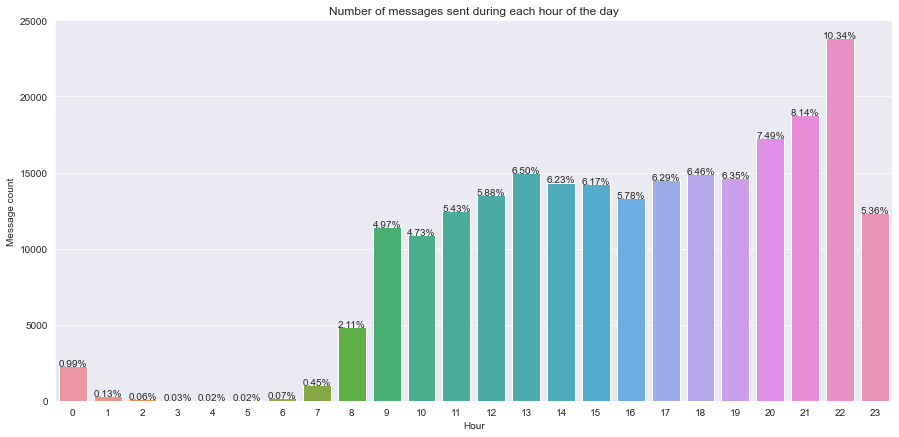

In [79]:
msgs_per_hour = df.groupby(by=['Time'], as_index=False)['Content'].count()
msgs_per_hour['Time'] = pd.to_datetime(msgs_per_hour['Time'].map(lambda t: str(t))) # this is so dumb to do
msgs_per_hour = msgs_per_hour.groupby(pd.Grouper(key='Time', freq='1H')).sum().reset_index()
msgs_per_hour.rename(columns={'Content': 'Message count', 'Time': 'Hour'}, inplace=True)
missing_times = pd.date_range(start='00:00', end='23:00', freq='1H').difference(msgs_per_hour['Hour']).values
msgs_per_hour = pd.concat(
    [msgs_per_hour, pd.DataFrame(data=[[time, 0] for time in missing_times], columns=['Hour', 'Message count'])],
    ignore_index=True)
msgs_per_hour['Hour'] = msgs_per_hour['Hour'].map(lambda t: t.hour)

plt.figure(figsize=(15, 7))
ax = sns.barplot(x='Hour', y='Message count', data=msgs_per_hour)
ax.set_title("Number of messages sent during each hour of the day")

total_msgs = sum(msgs_per_hour['Message count'].to_numpy())

patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height() + 0.05
    ax.annotate('{:.2f}%'.format(msgs_per_hour['Message count'][i] / total_msgs * 100), (x, y), ha='center')
plt.show()

## Distribution of messages during the week

Similarly to the last visualization, I'll show the distribution of messages depending on the day of the week using a pie chart.

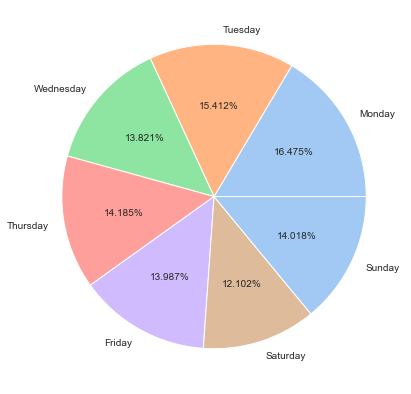

In [80]:
msgs_per_weekday = msgs_per_day.copy(deep=True)
msgs_per_weekday['Day'] = pd.to_datetime(msgs_per_weekday['Day'])
msgs_per_weekday['Day'] = msgs_per_weekday['Day'].map(lambda t: t.weekday())
msgs_per_weekday = msgs_per_weekday.groupby(by=['Day'], as_index=False).sum()
msgs_per_weekday.rename(columns={'Day': 'Day of the week'}, inplace=True)
msgs_per_weekday['Day of the week'] = msgs_per_weekday['Day of the week'].map(
    {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

plt.figure(figsize=(15, 7))
colors = sns.color_palette('pastel')[0:6]
pie = plt.pie(msgs_per_weekday['Message count'], labels=msgs_per_weekday['Day of the week'], colors=colors,
              autopct='%.3f%%')

## Statistical test to determine if messages per weekday have uniform distribution
### Chi-Squared Test
Chi-Squared test is used to determine whether the observed frequencies match the expected frequencies. I can take the observed number of messages per weekday and compared them to expected number of messages per weekday were it distributed uniformly (meaning each day would have `total_messages / 7` messages.

Null hypothesis: observed frequencies do not differ significantly from expected frequencies
Alternative hypothesis: ! null hypothesis
Assumption: all observed and expected frequencies are at least 5

In [81]:
from scipy.stats import chisquare

assert (msgs_per_weekday['Message count'] > 5).all()

stat, p_value = chisquare(f_obs=msgs_per_weekday['Message count'])
print(f"Chi-Squared Test: statistic={stat:.4f}, p-value={p_value:.4f}\nConclusion: {'Do not reject' if p_value >= alpha else 'Reject'} null hypothesis under significance level of {alpha}.")

Chi-Squared Test: statistic=1807.3200, p-value=0.0000
Conclusion: Reject null hypothesis under significance level of 0.05.


## The initiator

For this purpose, I'll define the initiator as the person who sends the first message in a day (past 5 AM) to figure out
which person initates the conversations more often.

In [82]:
msg_initiator = df[df['Time'] > pd.to_datetime('05:00').time()] # assume normal sleep schedule
msg_initiator = msg_initiator.groupby(by=['Date'], as_index=False).first()
msg_initiator['Author'].value_counts()

Korina    259
phoda     257
Name: Author, dtype: int64